# Bayesian Networks with PyMC3, NetworkX, and PMML
#### Example taken from Manufacturing Uncertainty with Bayesian Networks *(S. Nannapaneni et al. 2016)*

In [1]:
## For debbugging
%load_ext autoreload

In [2]:
## for debugging:
%aimport pmml.bn
%aimport pymcnet.net
%aimport pymcnet.expr_parse
%autoreload 1
from pymcnet.net import *
from pmml.bn import *  # for reading in PMML

In [3]:
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
%matplotlib inline

![weld](./weld.PNG)

The Volume of a weld is given as 
$$V = L\left(\frac{3}{4}lh+gt+\frac{l-g}{2}(t-e)\right)$$
Where V and L represent the volume of the weld and the length of the weld respectively. Assuming the filler and metal are the same material, we model the theoretical enery required for the weld process to be given as 

$$E = \rho(C_p(T_f-T_i)+H)V $$

where $E$, $\rho$, $C_p$, $T_f$, $T_i$, $H$ represent the theoretical minimum energy, density of the material, heat capacity, final and initial temperatures, and latent heat of the material

This can be codified as a Bayes Net. We assume that the dimensioning parameters $l$, $h$, $g$ are random variables, each with unknown distribution parameters $\mu, \sigma$ (assuming they are Normally distributed). 

    ![net](./weldBN.PNG)
In addition, we have observed values for $l$, $h$, $g$, allowing us to update the posterior distribution using MCMC (Or, in the case of PyMC3, the No-U-Turn Sampler a.k.a. NUTS)

Let's assume a uniform prior on the distribution parameters, and let the majority of the other parameters be constant/known ... leaving, say, $\rho$ to be stochastic with some known mean and variance. We want to know the distribution for E, which is calculated (like V) directly from the other variables. This makes $E,V$ *deterministic* variables. 

Using Daft to draw this PGM, we get a model like this:

<img src="./tests/weld_full/weld_net_img.png" width="400"/>

### Sampling the prior and posterior
To get an approximation for our current belief in the distribution for minimum energy usage, we will perform sampling without any observations, and then we will add observation attributes to the network

#### First, we need some "observed data"

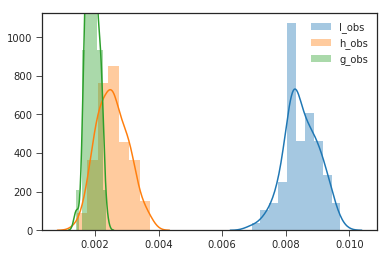

In [4]:
from scipy.stats import norm
import numpy as np
# Synthetic Data-set (observations)
np.random.seed(19806) #random.org, for reproduceability

num_obs = 100
l_obs = norm(8.5, 0.5).rvs(size=100)*1e-3
h_obs = norm(2.6, 0.5).rvs(size=100)*1e-3
g_obs = norm(1.9, .19).rvs(size=100)*1e-3
synth = pd.DataFrame(data=np.array([l_obs, h_obs, g_obs]).T, 
                     columns=['l','h','g'])
for i in [l_obs, h_obs, g_obs]:
    sns.distplot(i)
plt.legend([
    'l_obs',
    'h_obs',
    'g_obs'
])

### The unobserved (a.k.a. "prior") network: 

If you already know how to build networks using NetworkX, it's easy to model this BN. Nodes that depend on others will get a string definition in an `exprs` property, while independent nodes can simply receive their values directly --- after compilation the exprs property will be parsed into a form like the independent nodes, but using **Theano** shared variables. 

With this approach to prototyping, we can immediately check our model graphically without needing to compile the theano graph. 

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


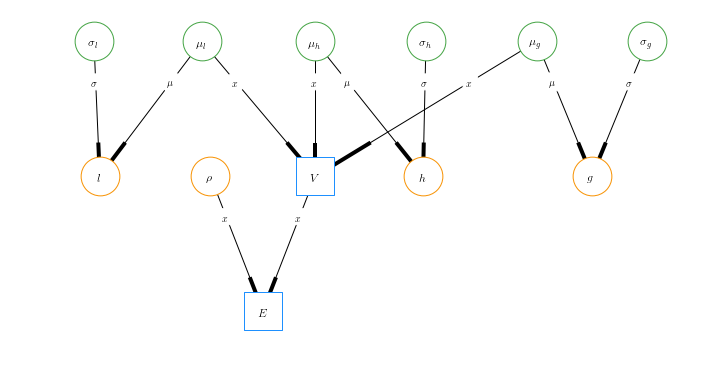

In [6]:
D = BayesianNetwork()

D.add_node('mu_l',
           lower=8.3e-3, upper=8.6e-3,
           dist_type='Uniform')
D.add_node('sd_l',
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')

D.add_node('l',
           dist_type='Normal',
           exprs = {'mu':'mu_l',
                    'sd':'sd_l'})
D.add_edge('mu_l','l', var='mu')
D.add_edge('sd_l', 'l', var='sd')

D.add_node('mu_h',
           lower=2.5e-3, upper=2.8e-3,
           dist_type='Uniform')
D.add_node('sd_h',
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')

D.add_node('h',
           dist_type='Normal',
           exprs = {'mu':'mu_h',
                    'sd':'sd_h'})
D.add_edge('mu_h','h', var='mu')
D.add_edge('sd_h', 'h', var='sd')

D.add_node('mu_g',
           lower=1.6e-3, upper=2.2e-3,
           dist_type='Uniform')
D.add_node('sd_g',
           lower=0.05e-3, upper=.2e-3,
           dist_type='Uniform')

D.add_node('g',
           dist_type='Normal',
           exprs = {'mu':'mu_g',
                    'sd':'sd_g'})
D.add_edge('mu_g','g', var='mu')
D.add_edge('sd_g', 'g', var='sd')

e = .011
L = .500
t = .015

D.add_node('V',
           dist_type='Deterministic',
           exprs = {'var':f'{L}*((0.75)*mu_l*mu_h + mu_g*{t} + (mu_l-mu_g)*({t}-{e})*0.5)'})

D.add_edges_from([(i,'V') for i in ['mu_l','mu_h','mu_g']],
                 var='x')

D.add_node('rho',
           mu=8250., sd=10.,
          dist_type='Normal')

H=270.
C_p=500.
T_i=300.
T_f=1600.

D.add_node('E',
           dist_type = 'Deterministic',
           exprs={'var':f'rho*V*({C_p}*({T_f}-{T_i}) + {H})'})
D.add_edges_from([(i, 'E') for i in ['rho','V']], var='var')


draw_net(D, pretty=True)

#### The observations can be easily added in: 
Note the graph visualization automatically checks for observed nodes

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


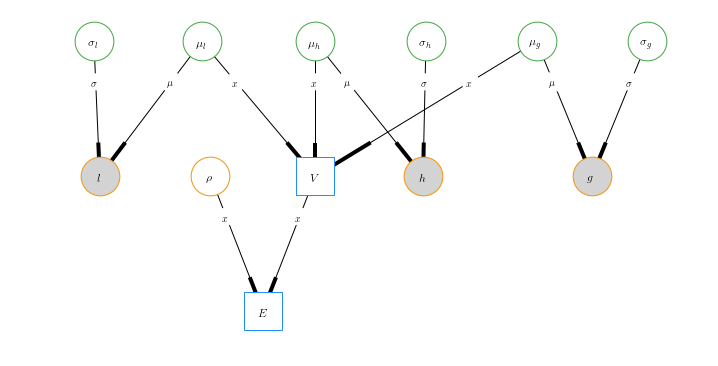

In [7]:
# import theano.tensor as T
# O = BayesianNetwork()

O = D.copy()
O.node['l']['observed'] = synth['l']
O.node['h']['observed'] = synth['h']
O.node['g']['observed'] = synth['g']


draw_net(O, pretty=True)

### Instantiation (i.e. Theano Comiling) and Sampling is easy!

In [8]:
n_samp = 2000

with pm.Model() as prior_model:
#     db_prior = pm.backends.Text('trace_prior_file')
    instantiate_pm(D, evaluate_exprs=True)
    trace_prior = pm.sample(n_samp, njobs=16)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['mu', 'sd']

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...



mu_g
root node; keys:  ['upper', 'lower']
sd_g
root node; keys:  ['upper', 'lower']
g
child node; keys:  ['mu', 'sd']
V
child node; keys:  ['var']
rho
root node; keys:  ['mu', 'sd']
E
child node; keys:  ['var']


Average Loss = 4.4862:  22%|██▏       | 43998/200000 [00:06<00:22, 6965.24it/s]    
Convergence archived at 44500
Interrupted at 44,500 [22%]: Average Loss = 1.0519e+06
  0%|          | 0/2500 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '23842' (I am process '23827')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/tbsexton/.theano/compiledir_Linux-4.12--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
100%|██████████| 2500/2500 [00:32<00:00, 76.18it/s] 


In [9]:
with pm.Model() as model:
#     db = pm.backends.Text('trace_file')
    instantiate_pm(O, evaluate_exprs=True)
    trace = pm.sample(n_samp, njobs=16)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['observed', 'mu', 'sd']
mu_g
root node; keys:  ['upper', 'lower']
sd_g
root node; keys:  ['upper', 'lower']
g
child node; keys:  ['observed', 'mu', 'sd']
V
child node; keys:  ['var']
rho
root node; keys:  ['mu', 'sd']
E
child node; keys:  ['var']


Average Loss = -1,940.3:   6%|▌         | 11826/200000 [00:01<00:28, 6540.79it/s]
Convergence archived at 12500
Interrupted at 12,500 [6%]: Average Loss = -1,928.6
 98%|█████████▊| 2442/2500 [00:10<00:00, 587.12it/s]/home/tbsexton/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.889571228795, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [00:10<00:00, 235.11it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '24185' (I am process '24180')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/tbsexton/.theano/compiledir_Linux-4.12--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.2-64/lock_dir
/home/tbsexton/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 2 doe

#### Plot the updated belief

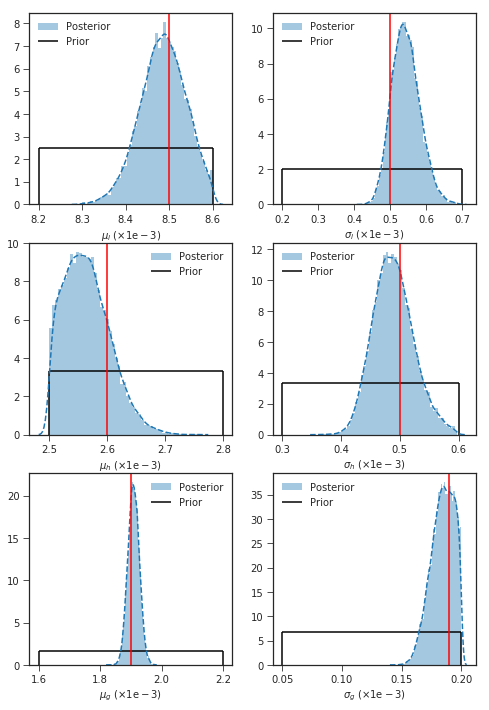

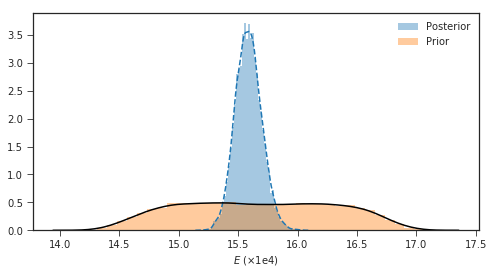

In [10]:
lims = [(8.2e-3, 8.6e-3),
        (0.2e-3, 0.7e-3),
        (2.5e-3, 2.8e-3),
        (0.3e-3, 0.6e-3),
        (1.6e-3, 2.2e-3),
        (.05e-3, 0.2e-3)]
trues = [8.5, 0.5, 2.6, 0.5, 1.9, .19]
varnames=['mu_l', 'sd_l',
          'mu_h', 'sd_h',
          'mu_g', 'sd_g']
varlabs= [r'$\mu_l$', r'$\sigma_l$',
          r'$\mu_h$', r'$\sigma_h$',
          r'$\mu_g$', r'$\sigma_g$']

def compare_dist(ax, dat, lim, true=None, scale=1.):
    sns.distplot(scale*dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
    a,b = scale*lim[0], scale*lim[1]
    y = 1./(b-a)
    ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
    ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
    if true is not None:
        ax.axvline(true, color='r')
    ax.legend()

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,12))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp//2:].get_values(D.d(varnames[n])), lims[n], true=trues[n], scale=1e3)
    ax.set_xlabel(f"{varlabs[n]}"+ r" ($\times 1\mathrm{e}-3$)")
plt.show()

f2 = plt.figure(figsize=(8,4))
sns.distplot(trace[n_samp//2:].get_values('E')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp//2:].get_values('E')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel(r'$E$ $(\times 1\mathrm{e}4)$')
# plt.xlim(10,35)
plt.show()

#### Check convergence of the Sampler

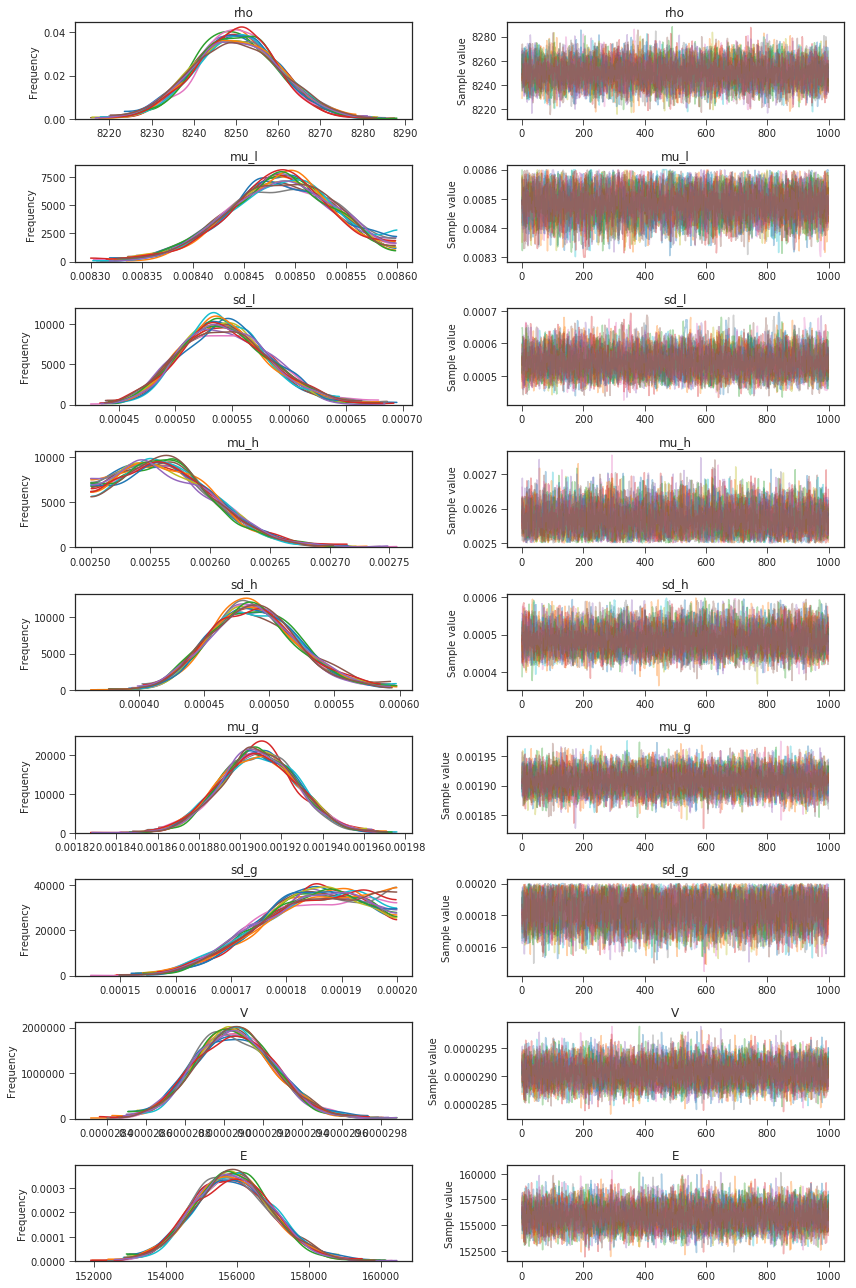

In [11]:
pm.traceplot(trace[n_samp//2:], combined=False);

### Serialization
This model is compatible with the PMML parser contained in this package. To save it, just call the `toPMML()` network method 

In [12]:
O.toPMML('WeldModelPMML.xml')

mu_l
	 Lower 0.0083
	 Upper 0.0086
sd_l
	 Lower 0.0002
	 Upper 0.0007
l
	 Mean mu_l
	 Variance (sd_l)**2.
mu_h
	 Lower 0.0025
	 Upper 0.0028
sd_h
	 Lower 0.0003
	 Upper 0.0006
h
	 Mean mu_h
	 Variance (sd_h)**2.
mu_g
	 Lower 0.0016
	 Upper 0.0022
sd_g
	 Lower 5e-05
	 Upper 0.0002
g
	 Mean mu_g
	 Variance (sd_g)**2.
V
	 Mean 0.5*((0.75)*mu_l*mu_h + mu_g*0.015 + (mu_l-mu_g)*(0.015-0.011)*0.5)
rho
	 Mean 8250.0
	 Variance 100.0
E
	 Mean rho*V*(500.0*(1600.0-300.0) + 270.0)
Wrote PMML file to WeldModelPMML.xml


## Reading PMML Files In 

Given some PMML bayes-net file, we can import into our BayesianNetwork graph object, and immediately instantiate into a PyMC3 model. 

Let's try it now: 

In [13]:
bnp = BayesianNetworkParser()

soG = bnp.parse('WeldModelPMML.xml')
soG.node

mu_l
	lower 0.0083
	upper 0.0086
sd_l
	lower 0.0002
	upper 0.0007
l
	mu ['mu_l']
	sd ['sd_l']
mu_h
	lower 0.0025
	upper 0.0028
sd_h
	lower 0.0003
	upper 0.0006
h
	mu ['mu_h']
	sd ['sd_h']
mu_g
	lower 0.0016
	upper 0.0022
sd_g
	lower 5e-05
	upper 0.0002
g
	mu ['mu_g']
	sd ['sd_g']
V
	mu ['mu_l', 'mu_g', 'mu_h', 'mu_l']
	sd []
Deterministic Node V detected as N(mu, 0); replacing...
rho
	mu 8250.0
	sd 100.0
E
	mu ['V', 'rho']
	sd []
Deterministic Node E detected as N(mu, 0); replacing...


OrderedDict([('mu_l',
              {'dist_type': 'Uniform', 'lower': 0.0083, 'upper': 0.0086}),
             ('sd_l',
              {'dist_type': 'Uniform', 'lower': 0.0002, 'upper': 0.0007}),
             ('l',
              {'dist_type': 'Normal',
               'exprs': {'mu': 'mu_l', 'sd': '(sd_l**2.0)**0.5'},
               'observed': []}),
             ('mu_h',
              {'dist_type': 'Uniform', 'lower': 0.0025, 'upper': 0.0028}),
             ('sd_h',
              {'dist_type': 'Uniform', 'lower': 0.0003, 'upper': 0.0006}),
             ('h',
              {'dist_type': 'Normal',
               'exprs': {'mu': 'mu_h', 'sd': '(sd_h**2.0)**0.5'},
               'observed': []}),
             ('mu_g',
              {'dist_type': 'Uniform', 'lower': 0.0016, 'upper': 0.0022}),
             ('sd_g',
              {'dist_type': 'Uniform', 'lower': 5e-05, 'upper': 0.0002}),
             ('g',
              {'dist_type': 'Normal',
               'exprs': {'mu': 'mu_g', 'sd': '(sd_

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


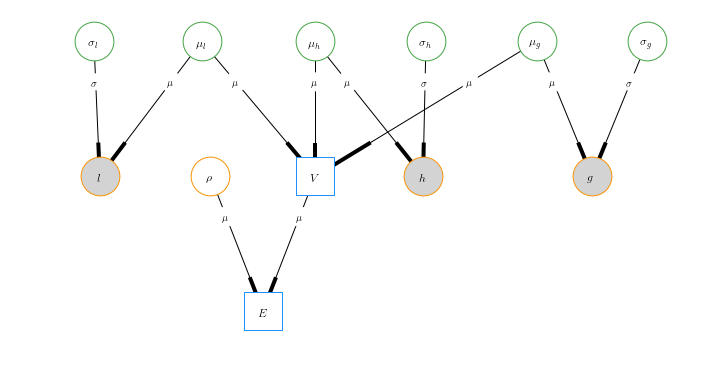

In [14]:
draw_net(soG, pretty=True)

Note that PMML as implemented here does not save the training/observation data, but it will flag which nodes are *supposed* to be observed, as specified in the XML document (note the yellow nodes above). 

We can make another net that will contain the observations, and then set off PyMC3 to do our sampling:

In [15]:
soO = soG.copy()
soO.node['l']['observed'] = synth['l']
soO.node['h']['observed'] = synth['h']
soO.node['g']['observed'] = synth['g']


n_samp = 2000

with pm.Model() as prior_model:
    instantiate_pm(soG, evaluate_exprs=True)
    trace_prior = pm.sample(n_samp)

with pm.Model() as model:
    instantiate_pm(soO, evaluate_exprs=True)
    trace = pm.sample(n_samp)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


child node; keys:  ['observed', 'mu', 'sd']
mu_g
root node; keys:  ['upper', 'lower']
sd_g
root node; keys:  ['upper', 'lower']
g
child node; keys:  ['observed', 'mu', 'sd']
V
child node; keys:  ['var']
rho
root node; keys:  ['mu', 'sd']
E
child node; keys:  ['var']


Average Loss = 0.14847:  15%|█▍        | 29703/200000 [00:04<00:26, 6344.24it/s]
Convergence archived at 30000
Interrupted at 30,000 [15%]: Average Loss = 0.87348
100%|██████████| 2500/2500 [00:04<00:00, 513.13it/s]


mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


child node; keys:  ['observed', 'mu', 'sd']
mu_g
root node; keys:  ['upper', 'lower']
sd_g
root node; keys:  ['upper', 'lower']
g
child node; keys:  ['observed', 'mu', 'sd']
V
child node; keys:  ['var']
rho
root node; keys:  ['mu', 'sd']
E
child node; keys:  ['var']


Average Loss = -1,940.3:   6%|▌         | 11939/200000 [00:01<00:28, 6601.47it/s]
Convergence archived at 12500
Interrupted at 12,500 [6%]: Average Loss = -1,928.6
100%|██████████| 2500/2500 [00:04<00:00, 573.65it/s]


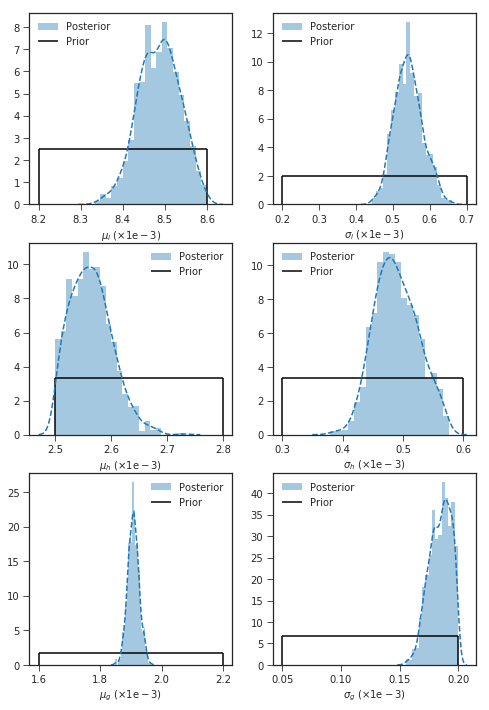

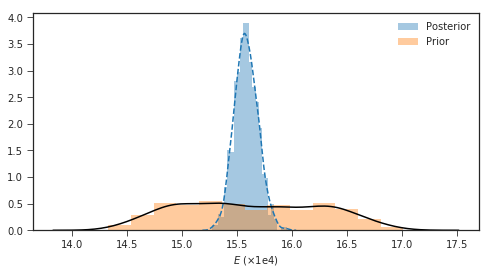

In [16]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,12))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp//2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
    ax.set_xlabel(f"{varlabs[n]}"+ r" ($\times 1\mathrm{e}-3$)")
plt.show()

f2 = plt.figure(figsize=(8,4))
sns.distplot(trace[n_samp//2:].get_values('E')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp//2:].get_values('E')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel(r'$E$ $(\times 1\mathrm{e}4)$')
# plt.xlim(15,35)
plt.show()

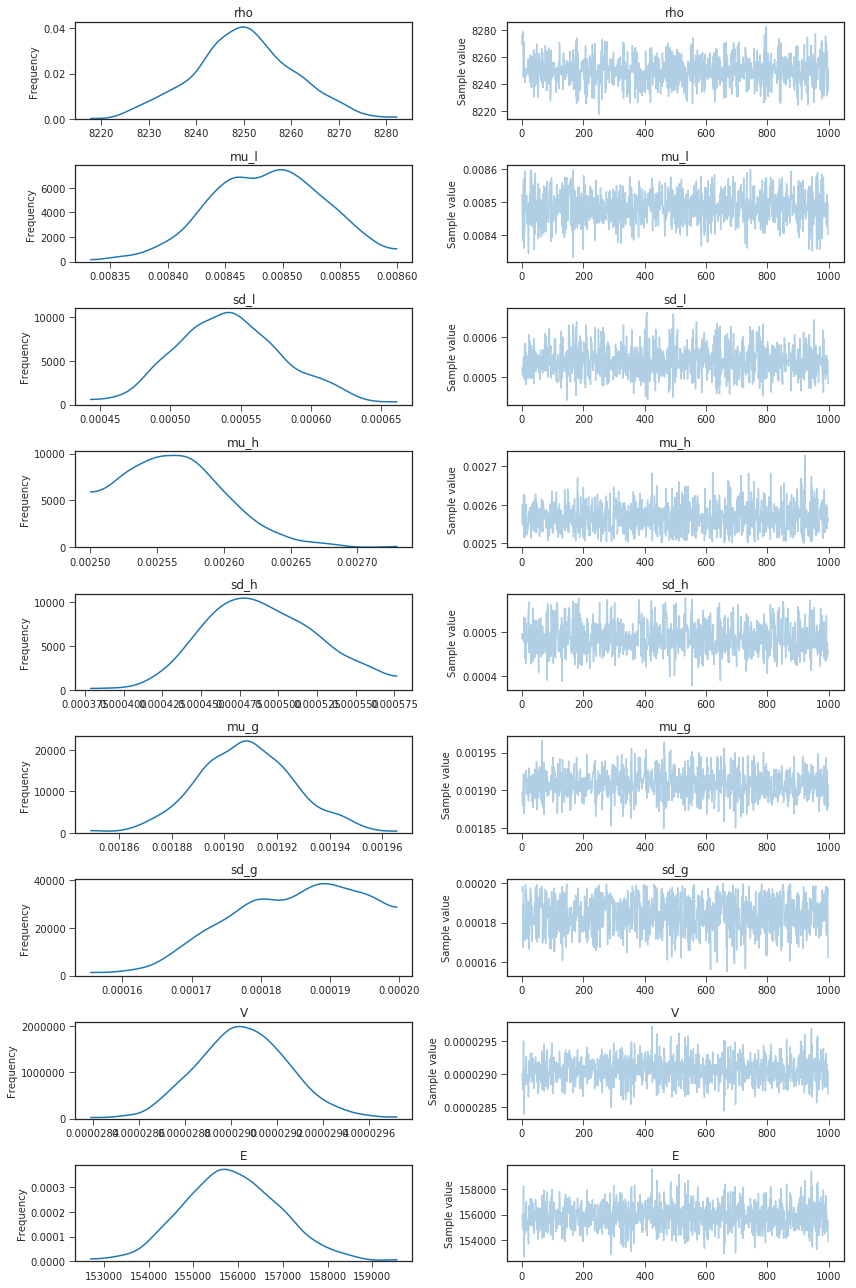

In [17]:
pm.traceplot(trace[n_samp//2:]);